## Accessing Fish and Wildlife Service's National Wetlands Inventory (FWS NWI) with the Planetary Computer

The [National Wetlands Inventory](https://www.fws.gov/program/national-wetlands-inventory) was established by the U.S. Fish and Wildlife Service (Service) to conduct a nationwide inventory of U.S. wetlands to provide biologists and others with information on the distribution and type of wetlands to aid conservation efforts. To do this, the NWI developed a wetland classification system that is now the official wetland classification system for the Service and the federal standard for wetland classification (61 FR 39465). The NWI also developed techniques for mapping and recording the inventory findings. 

The Wetlands Data Layer, which is hosted on the Planetary Computer, is the product of over 45 years of work by the National Wetlands Inventory (NWI) and its collaborators and currently contains more than 35 million wetland and deepwater features. This dataset, covering the conterminous United States, Hawaii, Puerto Rico, the Virgin Islands, Guam, the major Northern Mariana Islands and Alaska, continues to grow at a rate of 50 to100 million acres annually as data are updated. The data layer is updated twice a year and these changes are reflected on the mapper and in the data downloads.

The data are provided in their source zipfiles, grouped by state, and as [geoparquet](https://github.com/opengeospatial/geoparquet) datasets. Documentation for this dataset is available at the [Planetary Computer Catalog](https://planetarycomputer.microsoft.com/dataset/fws-nwi).

### Data access

This notebook works with or without and API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable `PC_SDK_SUBSCRIPTION_KEY` when your server is started. The API key may be manually set via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [1]:
import planetary_computer
from pystac_client import Client

URL = "https://planetarycomputer.microsoft.com/api/stac/v1/"
client = Client.open(URL, modifier=planetary_computer.sign_inplace)
collection = client.get_collection("fws-nwi")
print(collection)

<CollectionClient id=fws-nwi>


### Collection summaries

Each FWS [item](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) corresponds to a state (or similar administrative unit). A summary of the available codes is available on the [collection](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md).

In [2]:
from rich.table import Table

summaries = collection.summaries
states = Table("State code", "State")
for state_code, state in zip(
    summaries.get_list("fws_nwi:state_code"), summaries.get_list("fws_nwi:state")
):
    states.add_row(state_code, state)
states

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ State code ┃ State                          ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AL         │ Alabama                        │
│ AK         │ Alaska                         │
│ AZ         │ Arizona                        │
│ AR         │ Arkansas                       │
│ CA         │ California                     │
│ CO         │ Colorado                       │
│ CT         │ Connecticut                    │
│ DE         │ Delaware                       │
│ DC         │ District of Columbia           │
│ FL         │ Florida                        │
│ GA         │ Georgia                        │
│ HI         │ Hawaii                         │
│ ID         │ Idaho                          │
│ IL         │ Illinois                       │
│ IN         │ Indiana                        │
│ IA         │ Iowa                           │
│ KS         │ Kansas                         │
│ KY         │ Kentucky                       │
│ LA         │ Louisiana                      │
│ ME         │ Maine                          │
│ MD         │ Maryland                       │
│ MA         │ Massachusetts                  │
│ MI         │ Michigan                       │
│ MN         │ Minnesota                      │
│ MS         │ Mississippi                    │
│ MO         │ Missouri                       │
│ MT         │ Montana                        │
│ NE         │ Nebraska                       │
│ NV         │ Nevada                         │
│ NH         │ New Hampshire                  │
│ NJ         │ New Jersey                     │
│ NM         │ New Mexico                     │
│ NY         │ New York                       │
│ NC         │ North Carolina                 │
│ ND         │ North Dakota                   │
│ OH         │ Ohio                           │
│ OK         │ Oklahoma                       │
│ OR         │ Oregon                         │
│ PacTrust   │ Pacific Trust Islands          │
│ PA         │ Pennsylvania                   │
│ PRVI       │ Puerto Rico and Virgin Islands │
│ RI         │ Rhode Island                   │
│ SC         │ South Carolina                 │
│ SD         │ South Dakota                   │
│ TN         │ Tennessee                      │
│ TX         │ Texas                          │
│ UT         │ Utah                           │
│ VT         │ Vermont                        │
│ VA         │ Virginia                       │
│ WA         │ Washington                     │
│ WV         │ West Virginia                  │
│ WI         │ Wisconsin                      │
│ WY         │ Wyoming                        │
└────────────┴────────────────────────────────┘

### Fetching a single area's data

FWS NWI items have their state code as their ID, so it's easy to get the STAC item from, e.g., Washington, DC.

In [3]:
item = collection.get_item("DC")

### Item assets

Every item has its source zipfile as an asset. It also has all shapefiles in the zipfile as assets, converted to geoparquet tables. Each state has its own layout, so you'll need to query the assets to see what's available.

There's three types of roles that geoparquet assets might have (text taken from the original FWS NWI metadata):
- Wetlands: This data set represents the extent, approximate location and type of wetlands and deepwater habitats in the United States and its Territories. These data delineate the areal extent of wetlands and surface waters as defined by Cowardin et al. (1979), which represents a biological definition of wetlands and deepwater habitats. There is no attempt to define the limits of proprietary jurisdiction of any Federal, State, or local government, or to establish the geographical scope of the regulatory programs of government agencies. Some wetland habitats may be under represented or excluded in certain areas because of the limitations of aerial imagery as the primary data source used to detect wetlands. These habitats include seagrasses or submerged aquatic vegetation that are found in the intertidal and subtidal zones of estuaries and near shore coastal waters and also some deepwater reef communities (coral or tuberficid worm reefs). These habitats, because of their depth and water clarity, go undetected by most aerial imagery. By policy, the Service also excludes certain types of "farmed wetlands" as may be defined by the Food Security Act or that do not coincide with the Cowardin et al. definition.
- Historic wetlands: This data set represents the extent and approximate location of historic wetland habitats in certain areas of the conterminous United States. The identification of these historic wetlands is limited by the methodology outlined in the associated Historic Wetlands Project Metadata and is not intended to be a comprehensive inventory of all historic wetlands. The U.S. Fish and Wildlife Service (Service) is the principal Federal agency that provides information to the public on the extent and status of the Nation's wetlands and provides stewardship for the wetlands data that comprise the Wetlands Layer of the National Spatial Data Infrastructure. In the formulation of this data layer, historic wetlands are defined as areas where there is evidence that a wetland once existed. This evidence can be from historical map information inventories of past wetland extent or other information collected that relate directly to data on wetland filling, drainage or other modifications. Historic wetlands have been identified using several different techniques depending on the availability and type of information used to locate these areas and user needs. For example, historical maps often provide information about past wetland extent or location and can be useful tools to identify historic wetlands. Historic wetlands have been identified as polygonal data. No linear features have been included. Historic wetland polygons are not classified as wetlands and have no wetland labels or attribution. Since these features no longer exist, boundary delineations are considered approximations based on topography, previously mapped information or indications of historic water levels.
- Riparian: This data set represents the extent, approximate location and type of riparian habitats in the western United States. These data delineate the areal extent of riparian habitats as defined by A System For Mapping Riparian Areas in the United States (USFWS 2009). Certain riparian habitats may be excluded from the National mapping program because of the limitations of aerial imagery as the primary data source used to detect riparian habitats. This dataset should be used in conjuction with the Riparian Mapping Areas layer, which identifies the extent and location of Riparian mapping projects.


In [4]:
assets = Table("Key", "Media type", "Title", "Roles")
for key, asset in item.assets.items():
    assets.add_row(key, asset.media_type, asset.title, ", ".join(asset.roles))
assets

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                         ┃ Media type            ┃ Title                       ┃ Roles                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ zip                         │ application/zip       │ DC_shapefile_wetlands       │ data, archive, source       │
│ DC_Wetlands                 │ application/x-parquet │ DC Wetlands                 │ data, cloud-optimized,      │
│                             │                       │                             │ wetlands                    │
│ District_of_Columbia        │ application/x-parquet │ District of Columbia        │ data, cloud-optimized       │
│ DC_Wetlands_Project_Metada… │ application/x-parquet │ DC Wetlands Project         │ data, cloud-optimized       │
│                             │                       │ Metadata                    │                             │
│ DC_Wetlands_Historic_Map_I… │ application/x-parquet │ DC Wetlands Historic Map    │ data, cloud-optimized       │
│                             │                       │ Info                        │                             │
└─────────────────────────────┴───────────────────────┴─────────────────────────────┴─────────────────────────────┘

### Reading geoparquet data

As you can see, the Washington, DC item only has `wetlands` data. Other items may have `riparian` or `historical_wetlands` roles as well, and may have multiple geoparquet tables per role, e.g. for large states where the shapefiles have been partitioned into regions.
For this small area, let's visualize the wetlands data in the geoparquet file.

In [5]:
import geopandas
import fsspec.implementations.http

asset = item.assets["DC_Wetlands"]
dataframe = geopandas.read_parquet(
    asset.href, filesystem=fsspec.implementations.http.HTTPFileSystem()
)
dataframe

,ATTRIBUTE,WETLAND_TY,ACRES,Shape_Leng,Shape_Area,geometry
0,L1UBH,Lake,106.822629,3332.932665,4.322962e+05,"POLYGON ((1619201.392 1923894.398, 1619200.410..."
1,L1UBHh,Lake,38.541527,2007.802784,1.559722e+05,"POLYGON ((1619541.030 1928956.200, 1619565.720..."
2,L1UBHh,Lake,42.637706,3166.679695,1.725488e+05,"POLYGON ((1611498.730 1929400.030, 1611484.420..."
3,L1UBHx,Lake,15.102323,15297.418233,6.111699e+04,"POLYGON ((1610880.264 1928432.972, 1610883.922..."
4,L1UBKx,Lake,40.736128,1734.863664,1.648534e+05,"POLYGON ((1613706.270 1925857.040, 1613701.600..."
...,...,...,...,...,...,...
1551,PFO1E,Freshwater Forested/Shrub Wetland,4.258138,1351.527390,1.723209e+04,"MULTIPOLYGON (((1616401.132 1908155.934, 16163..."
1552,R5UBFx,Riverine,1.660922,3359.514699,6.721520e+03,"POLYGON ((1621293.112 1920949.423, 1621293.322..."
1553,PFO1A,Freshwater Forested/Shrub Wetland,1.806834,2078.463001,7.312006e+03,"MULTIPOLYGON (((1625775.457 1910076.169, 16257..."
1554,R3UBH,Riverine,0.129664,168.401644,5.247319e+02,"MULTIPOLYGON (((1612942.967 1915173.152, 16129..."


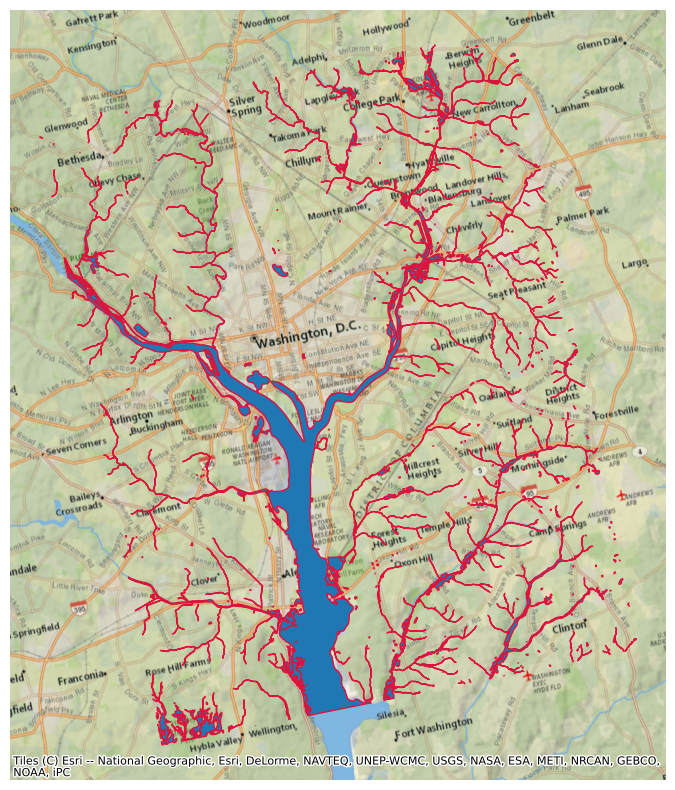

In [6]:
import contextily

ax = dataframe.plot(figsize=(10, 10), edgecolor="crimson")
contextily.add_basemap(
    ax, crs=str(dataframe.crs), source=contextily.providers.Esri.NatGeoWorldMap
)
ax.set_axis_off()

For larger states with multiple parquet tables, use asset roles to select the specific assets you want.

In [7]:
california = collection.get_item("CA")
list(california.assets)

['zip',
 'California',
 'CA_Riparian',
 'CA_Wetlands',
 'CA_Wetlands_North',
 'CA_Wetlands_South',
 'CA_Wetlands_NorthCentral',
 'CA_Wetlands_SouthCentral',
 'CA_Riparian_Project_Metadata',
 'CA_Wetlands_Project_Metadata',
 'CA_Wetlands_Historic_Map_Info']

In [8]:
[
    key
    for key, asset in california.assets.items()
    if "cloud-optimized" in asset.roles and "wetlands" in asset.roles
]

['CA_Wetlands',
 'CA_Wetlands_North',
 'CA_Wetlands_South',
 'CA_Wetlands_NorthCentral',
 'CA_Wetlands_SouthCentral']